In [1]:
import pandas as pd

# Load the preprocessed dataset
preprocessed_file = "preprocessed_spam_emails50k.csv"
preprocessed_df = pd.read_csv(preprocessed_file)

# Display the first few rows of the dataset
print(preprocessed_df.head())

                                      Message-ID  Date  \
0  <18782981.1075855378110.JavaMail.evans@thyme>   NaN   
1  <15464986.1075855378456.JavaMail.evans@thyme>   NaN   
2  <24216240.1075855687451.JavaMail.evans@thyme>   NaN   
3  <13505866.1075863688222.JavaMail.evans@thyme>   NaN   
4  <30922949.1075863688243.JavaMail.evans@thyme>   NaN   

                      From                       To    Subject  \
0  phillip.allen@enron.com     tim.belden@enron.com    Unknown   
1  phillip.allen@enron.com  john.lavorato@enron.com        Re:   
2  phillip.allen@enron.com   leah.arsdall@enron.com   Re: test   
3  phillip.allen@enron.com    randall.gay@enron.com    Unknown   
4  phillip.allen@enron.com     greg.piper@enron.com  Re: Hello   

                                                Body Spam_Label  
0                               Here is our forecast   Not Spam  
1  Traveling to have a business meeting takes the...   Not Spam  
2                     test successful.  way to go!!!   N

In [2]:
import re
from datetime import datetime
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check if GPU is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the spam detection model and tokenizer (example: fine-tuned BERT for spam classification)
spam_model_name = "mrm8488/bert-tiny-finetuned-sms-spam-detection"
tokenizer = AutoTokenizer.from_pretrained(spam_model_name)
spam_model = AutoModelForSequenceClassification.from_pretrained(spam_model_name)
spam_model.to(device)

# Function to classify emails as Spam or Not Spam
def get_spam_label(text):
    # Handle empty or very short text
    if not text.strip():
        return "Not Spam"  # Default label
    
    # Tokenize and prepare the input for the model
    tokens = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    
    # Get spam classification prediction
    with torch.no_grad():
        outputs = spam_model(tokens)
        scores = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    
    # Labels: [0: "Not Spam", 1: "Spam"]
    return "Spam" if scores[1] > scores[0] else "Not Spam"

# Add a new column for spam classification (if not already present)
if 'Spam_Label' not in preprocessed_df.columns:
    preprocessed_df['Spam_Label'] = preprocessed_df['Body'].apply(get_spam_label)

# Display the first few rows of the dataset with spam labels
print(preprocessed_df.head())

Using device: cuda
                                      Message-ID  Date  \
0  <18782981.1075855378110.JavaMail.evans@thyme>   NaN   
1  <15464986.1075855378456.JavaMail.evans@thyme>   NaN   
2  <24216240.1075855687451.JavaMail.evans@thyme>   NaN   
3  <13505866.1075863688222.JavaMail.evans@thyme>   NaN   
4  <30922949.1075863688243.JavaMail.evans@thyme>   NaN   

                      From                       To    Subject  \
0  phillip.allen@enron.com     tim.belden@enron.com    Unknown   
1  phillip.allen@enron.com  john.lavorato@enron.com        Re:   
2  phillip.allen@enron.com   leah.arsdall@enron.com   Re: test   
3  phillip.allen@enron.com    randall.gay@enron.com    Unknown   
4  phillip.allen@enron.com     greg.piper@enron.com  Re: Hello   

                                                Body Spam_Label  
0                               Here is our forecast   Not Spam  
1  Traveling to have a business meeting takes the...   Not Spam  
2                     test successful

In [3]:
# Split dataset into train and test sets
from sklearn.model_selection import train_test_split

# Define input (email body) and labels (spam or not spam)
text_X = preprocessed_df["Body"]
labels_y = preprocessed_df["Spam_Label"]  # Ensure this column is preprocessed or added during spam detection

# Train-test split (80% training, 20% testing)
text_X_train, text_X_test, labels_y_train, labels_y_test = train_test_split(
    text_X, labels_y, test_size=0.2, random_state=42
)

# Print dataset sizes
print("Training samples:", len(text_X_train))
print("Testing samples:", len(text_X_test))


Training samples: 40000
Testing samples: 10000


In [4]:
# Final definition for the batched tensor conversion function
import torch
import tqdm
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer

def text_to_tensor_batched(text_list, model, tokenizer, device, batch_size=32, use_hidden_states=False):
    all_embeddings = []
    # Ensure text_list is actually a list
    if not isinstance(text_list, list):
        try:
            text_list = text_list.tolist()
        except AttributeError:
            raise TypeError("Input text_list must be a list or convertible to a list (e.g., pandas Series)")

    num_batches = (len(text_list) + batch_size - 1) // batch_size  # Calculate number of batches
    model.to(device) # Move model to device once

    for i in tqdm.tqdm(range(num_batches), desc="Processing batches"):
        # Get the current batch of text
        batch = text_list[i * batch_size : (i + 1) * batch_size]

        # Ensure all items in the batch are strings, handle potential None or non-string types
        processed_batch = [str(text) if text is not None else "" for text in batch]

        # Tokenize and convert text into tensors
        try:
            encoded_text = tokenizer(
                processed_batch, # Use the processed batch
                padding=True,
                truncation=True,
                max_length=512, # Standard max length
                return_tensors="pt",
                # Add error handling during tokenization if needed, though truncation helps
            )
        except Exception as e:
            print(f"Error tokenizing batch {i}: {e}")
            print(f"Problematic batch content (first few items): {processed_batch[:5]}")
            # Decide how to handle error: skip batch, return None, use dummy embeddings?
            # For now, we'll skip this batch, which might lead to shape mismatches later.
            # A more robust solution would involve identifying and cleaning the specific bad data point.
            continue # Skip this batch

        # Move tensors to the specified device
        input_ids = encoded_text["input_ids"].to(device)
        attention_mask = encoded_text["attention_mask"].to(device)

        # Extract embeddings using the transformer model
        with torch.no_grad():
            try:
                model_outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=use_hidden_states)

                # Use hidden states if specified, otherwise default to logits
                if use_hidden_states and hasattr(model_outputs, 'hidden_states') and model_outputs.hidden_states:
                     # Use the last hidden state and average pool
                    embeddings = model_outputs.hidden_states[-1].mean(dim=1)
                else:
                    # Fallback: If hidden states not available/requested, or if model is only classification head.
                    # Using logits is generally NOT good embeddings.
                    # Consider loading the base model separately if robust embeddings are needed without fine-tuning head.
                    # For this specific model/notebook structure, we'll keep using logits as a fallback.
                    # Warning: Logits might have different dimensionality and meaning than hidden states.
                    print(f"Warning: Using logits for batch {i} as hidden states are not available/requested.")
                    embeddings = model_outputs.logits

                # Move to CPU and convert to numpy BEFORE appending
                all_embeddings.append(embeddings.cpu().numpy())

            except Exception as e:
                print(f"Error during model inference for batch {i}: {e}")
                # Handle inference error - e.g., add placeholder embeddings of correct shape if possible
                # Or skip the batch (as done here)
                continue

    # Concatenate all embeddings into a single numpy array
    # Add check for empty list in case all batches failed
    if not all_embeddings:
         print("Warning: No embeddings were generated. Returning empty array.")
         # Determine expected embedding dimension (e.g., model.config.hidden_size for hidden states)
         # This depends on whether hidden states or logits were intended/used.
         # For bert-tiny, hidden size is 128. Logits size is usually num_labels (2 here).
         embed_dim = 128 if use_hidden_states else model.config.num_labels
         return np.empty((0, embed_dim), dtype=np.float32)

    try:
        return np.concatenate(all_embeddings, axis=0)
    except ValueError as e:
        print(f"Error concatenating embeddings: {e}")
        print("Embeddings from different batches might have inconsistent shapes.")
        # You might want to inspect the shapes of arrays in all_embeddings here
        # For now, returning an empty array or raising the error
        raise e # Or return an empty array of expected shape

In [5]:
# Convert to a list of strings if it's not already
text_X_train = text_X_train.astype(str).tolist() if not isinstance(text_X_train, list) else text_X_train
text_X_test = text_X_test.astype(str).tolist() if not isinstance(text_X_test, list) else text_X_test

# Convert text data to tensor representations using the corrected function
print("Converting training text to tensors...")
X_train_tensor = text_to_tensor_batched(text_X_train, spam_model, tokenizer, device, batch_size=64, use_hidden_states=True)
print("Converting test text to tensors...")
X_test_tensor = text_to_tensor_batched(text_X_test, spam_model, tokenizer, device, batch_size=64, use_hidden_states=True)

# Print the shapes of the resulting tensors for verification
# Add checks to ensure tensors are not empty
if X_train_tensor.size == 0 or X_test_tensor.size == 0:
    print("Error: Tensor conversion resulted in empty arrays. Check data and conversion function.")
else:
    print(f"X_train_tensor shape: {X_train_tensor.shape}")
    print(f"X_test_tensor shape: {X_test_tensor.shape}")

# Basic check for NaN values - might indicate issues
if np.isnan(X_train_tensor).any() or np.isnan(X_test_tensor).any():
     print("Warning: NaN values found in generated tensors.")


Converting training text to tensors...


Processing batches: 100%|█████████████████████████████████████████████████████████████| 625/625 [00:28<00:00, 21.73it/s]


Converting test text to tensors...


Processing batches: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.34it/s]

X_train_tensor shape: (40000, 128)
X_test_tensor shape: (10000, 128)


In [6]:
# Convert Pandas Series to list of strings (if necessary)
if isinstance(text_X_train, pd.Series):
    text_X_train = text_X_train.tolist()
if isinstance(text_X_test, pd.Series):
    text_X_test = text_X_test.tolist()

In [7]:
def text_to_tensor_batched(text_list, model, tokenizer, device, batch_size=32, use_hidden_states=False):
    all_embeddings = []
    num_batches = (len(text_list) + batch_size - 1) // batch_size  # Calculate number of batches

    for i in tqdm.tqdm(range(num_batches), desc="Processing batches"):
        # Get the current batch of text
        batch = text_list[i * batch_size : (i + 1) * batch_size]

        # Debug: Print the batch to verify its content
        print(f"Batch {i + 1}: {batch}")

        # Tokenize and convert text into tensors
        encoded_text = tokenizer(
            batch,  # Ensure batch is a list of strings
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        # Debug: Print the encoded text to verify its structure
        print(f"Encoded text: {encoded_text}")

        # Move tensors to the specified device
        input_ids = encoded_text["input_ids"].to(device)
        attention_mask = encoded_text["attention_mask"].to(device)

        # Extract embeddings using the transformer model
        with torch.no_grad():
            model_outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=use_hidden_states)

            # Use hidden states if specified, otherwise default to logits
            if use_hidden_states:
                embeddings = model_outputs.hidden_states[-1].mean(dim=1)  # Mean pooling over tokens
            else:
                embeddings = model_outputs.logits  # Default: classification logits

            all_embeddings.append(embeddings.cpu())  # Move to CPU to avoid memory issues

    # Concatenate all embeddings into a single tensor
    return torch.cat(all_embeddings, dim=0)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert labels to numerical format
y_train_encoded = label_encoder.fit_transform(labels_y_train)
y_test_encoded = label_encoder.transform(labels_y_test)

# Check label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label Mapping: {'Not Spam': 0, 'Spam': 1}


In [18]:
!pip install -U matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [9]:
from concrete.ml.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Initialize the XGBClassifier model
xgb_model = XGBClassifier()

# Define the grid of hyperparameters for tuning
param_grid = {
    "n_bits": [2, 3],                 # Number of bits for quantization
    "max_depth": [1],                 # Maximum depth of the trees
    "n_estimators": [10, 30, 50],     # Number of trees in the ensemble
}

# Initialize LabelEncoder for encoding labels
label_encoder = LabelEncoder()

# Ensure labels are encoded correctly
labels_y_train_encoded = label_encoder.fit_transform(labels_y_train)  # Encode training labels
y_test_encoded = label_encoder.transform(labels_y_test)  # Encode test labels using the same encoder

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,              # Model to tune
    param_grid=param_grid,            # Hyperparameter grid
    cv=5,                             # 5-fold cross-validation
    n_jobs=-1,                        # Use all available CPUs
    scoring="accuracy",               # Use accuracy as the scoring metric
    verbose=2                         # Verbosity for progress tracking
)

# Train the model using the grid search
print("Starting grid search...")
grid_search.fit(X_train_tensor, labels_y_train_encoded)  # Ensure correct variables are used
print("Grid search completed!")

# Get the best model and its parameters
best_xgb_model = grid_search.best_estimator_
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test_tensor)
test_accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test accuracy: {test_accuracy}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Starting grid search...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Grid search completed!
Best score: 0.8859999999999999
Best parameters: {'max_depth': 1, 'n_bits': 3, 'n_estimators': 50}
Test accuracy: 0.8862


--- Classification Report ---
              precision    recall  f1-score   support

    Not Spam       0.84      0.94      0.89      4740
        Spam       0.94      0.84      0.89      5260

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


--- Confusion Matrix ---


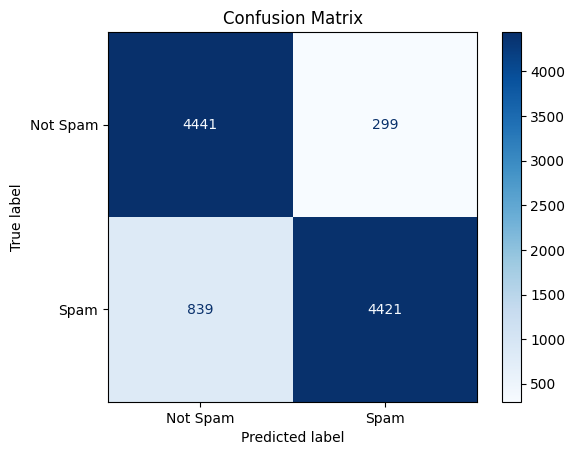


--- ROC Curve ---


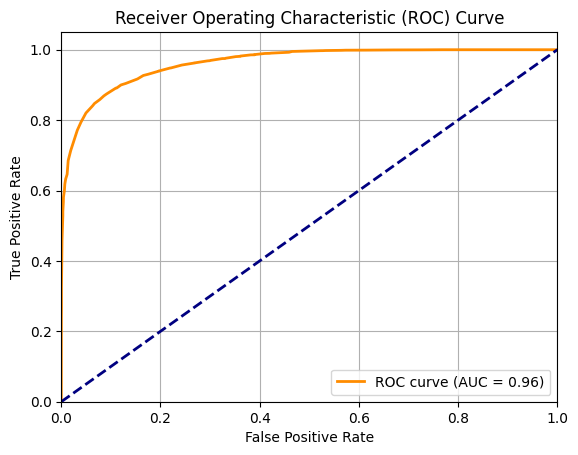


Area Under Curve (AUC): 0.9623

Accuracy: 0.8862


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Ensure that we are using the correct model and variables
# Make sure X_test_tensor and y_test_encoded exist from previous cells
if 'best_xgb_model' not in globals() or 'X_test_tensor' not in globals() or 'y_test_encoded' not in globals():
     print("Error: Required variables (best_xgb_model, X_test_tensor, y_test_encoded) not defined. Run previous cells.")
else:
    # Clear Predictions
    y_pred = best_xgb_model.predict(X_test_tensor)
    y_proba = best_xgb_model.predict_proba(X_test_tensor)[:, 1] # Probability of positive class (Spam)

    # --- Classification Report ---
    print("--- Classification Report ---")
    # Use label_encoder.classes_ to get the actual label names ("Not Spam", "Spam")
    target_names = label_encoder.classes_ if 'label_encoder' in globals() else ['Class 0', 'Class 1']
    print(classification_report(y_test_encoded, y_pred, target_names=target_names))

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    matrix = confusion_matrix(y_test_encoded, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # --- ROC Curve and AUC ---
    print("\n--- ROC Curve ---")
    fpr, tpr, thresholds = roc_curve(y_test_encoded, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"\nArea Under Curve (AUC): {roc_auc:.4f}")

    # Re-calculate and print accuracy for clarity
    accuracy_transformer_xgboost = np.mean(y_pred == y_test_encoded)
    print(f"\nAccuracy: {accuracy_transformer_xgboost:.4f}")


In [20]:
# --- Merged Cell: FHE vs Clear Inference Time (10 Samples) and Accuracy (Full Dataset) ---

import time
import numpy as np
import random
from sklearn.metrics import accuracy_score
import torch # Keep torch import if needed by models/tokenizers loaded earlier
from transformers import AutoModelForSequenceClassification, AutoTokenizer # Keep imports if needed
import tqdm # Import tqdm for progress bar on full dataset prediction

# --- Ensure necessary variables from previous cells exist ---
required_vars = [
    'best_xgb_model', 'X_train_tensor', 'text_X_test', 'X_test_tensor',
    'y_test_encoded', 'label_encoder', 'spam_model', 'tokenizer', 'device'
]
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"Missing required variables: {', '.join(missing_vars)}. Please run previous cells.")

# --- Compile the model for FHE (if not already compiled) ---
compile_time = 0
if not best_xgb_model.is_compiled:
    print("Compiling the model for FHE...")
    compile_start = time.perf_counter()
    best_xgb_model.compile(X_train_tensor)
    compile_end = time.perf_counter()
    compile_time = compile_end - compile_start
    print(f"Compilation time: {compile_time:.4f} seconds")
else:
    print("Model already compiled.")

# --- Select 10 random samples for TIMING ONLY ---
num_samples_timing = 10
random.seed(42) # for reproducibility
if len(text_X_test) < num_samples_timing:
     raise ValueError(f"Test set has fewer than {num_samples_timing} samples for timing.")

# Ensure text_X_test is a list if it's not already (should be from Cell 7)
if not isinstance(text_X_test, list):
     try:
         text_X_test_list = text_X_test.tolist()
     except AttributeError:
          raise TypeError("text_X_test is not a list or convertible to a list.")
else:
    text_X_test_list = text_X_test

random_indices_timing = random.sample(range(len(text_X_test_list)), num_samples_timing)
sample_embeddings_timing = X_test_tensor[random_indices_timing]

# --- Time Inference on 10 Samples ---
clear_times = []
fhe_times = []

print(f"\n--- Timing Inference on {num_samples_timing} Random Samples ---")
for i in range(num_samples_timing):
    embedding = sample_embeddings_timing[i].reshape(1, -1) # Predict expects 2D array

    # Clear Inference Timing
    clear_start = time.perf_counter()
    _ = best_xgb_model.predict_proba(embedding) # We only need the time
    clear_end = time.perf_counter()
    clear_times.append(clear_end - clear_start)

    # FHE Inference Timing
    fhe_start = time.perf_counter()
    _ = best_xgb_model.predict_proba(embedding, fhe="execute") # We only need the time
    fhe_end = time.perf_counter()
    fhe_times.append(fhe_end - fhe_start)

    print(f"Timing Sample {i+1}/{num_samples_timing} Processed - Clear: {clear_times[-1]:.6f}s, FHE: {fhe_times[-1]:.4f}s")

# Calculate Average Times
avg_clear_time = np.mean(clear_times)
avg_fhe_time = np.mean(fhe_times)
print("--- Timing Complete ---")


# --- Calculate Accuracy on the FULL Test Dataset ---
print(f"\n--- Calculating Accuracy on Full Test Set ({len(X_test_tensor)} samples) ---")

# Clear Predictions (Full Dataset) - Using predict_proba for consistency
print("Running clear predictions on full dataset...")
clear_proba_full = best_xgb_model.predict_proba(X_test_tensor)
clear_pred_labels_full = np.argmax(clear_proba_full, axis=1)
clear_accuracy_full = accuracy_score(y_test_encoded, clear_pred_labels_full)
print("Clear predictions finished.")

# FHE Predictions (Full Dataset) - Using predict_proba and iterating for progress
print("Running FHE predictions on full dataset (this may take time)...")
fhe_pred_labels_full = []
# Concrete ML's fhe="execute" might be slow in a single large batch, iterate if needed
# However, let's try the direct approach first. If it's too slow or errors, we can iterate.
try:
    fhe_proba_full = best_xgb_model.predict_proba(X_test_tensor, fhe="execute")
    fhe_pred_labels_full = np.argmax(fhe_proba_full, axis=1)
except Exception as e:
     print(f"Direct FHE prediction on full dataset failed ({e}). Iterating sample by sample...")
     fhe_pred_labels_full = []
     for idx in tqdm.tqdm(range(len(X_test_tensor)), desc="FHE Prediction Progress"):
         embedding_single = X_test_tensor[idx].reshape(1, -1)
         fhe_proba_single = best_xgb_model.predict_proba(embedding_single, fhe="execute")
         fhe_pred_labels_full.append(np.argmax(fhe_proba_single[0]))
     fhe_pred_labels_full = np.array(fhe_pred_labels_full)


if len(fhe_pred_labels_full) == len(y_test_encoded):
    fhe_accuracy_full = accuracy_score(y_test_encoded, fhe_pred_labels_full)
    mismatches_full = np.sum(clear_pred_labels_full != fhe_pred_labels_full)
    print("FHE predictions finished.")
else:
    print("FHE prediction failed or was interrupted. Cannot calculate FHE accuracy.")
    fhe_accuracy_full = -1 # Indicate failure
    mismatches_full = -1


# --- Print Summary ---
print("\n" + "="*30)
print("--- Final Summary ---")
if compile_time > 0:
     print(f"FHE Model Compilation Time: {compile_time:.4f} seconds")
print(f"Average Clear Inference Time ({num_samples_timing} samples): {avg_clear_time:.6f} seconds")
print(f"Average FHE Inference Time ({num_samples_timing} samples):   {avg_fhe_time:.4f} seconds")
print("-" * 25)
print(f"Clear Accuracy (Full Dataset): {clear_accuracy_full:.4f}")
if fhe_accuracy_full != -1:
    print(f"FHE Accuracy (Full Dataset):   {fhe_accuracy_full:.4f}")
    print(f"Mismatches between Clear and FHE predictions (Full Dataset): {mismatches_full}")
else:
    print("FHE Accuracy (Full Dataset): Could not be calculated.")
print("="*30)

Model already compiled.

--- Timing Inference on 10 Random Samples ---
Timing Sample 1/10 Processed - Clear: 0.004614s, FHE: 0.7696s
Timing Sample 2/10 Processed - Clear: 0.003915s, FHE: 0.5213s
Timing Sample 3/10 Processed - Clear: 0.006113s, FHE: 0.5370s
Timing Sample 4/10 Processed - Clear: 0.003151s, FHE: 0.4926s
Timing Sample 5/10 Processed - Clear: 0.003334s, FHE: 0.4967s
Timing Sample 6/10 Processed - Clear: 0.003067s, FHE: 0.4940s
Timing Sample 7/10 Processed - Clear: 0.002963s, FHE: 0.4927s
Timing Sample 8/10 Processed - Clear: 0.003073s, FHE: 0.4842s
Timing Sample 9/10 Processed - Clear: 0.003092s, FHE: 0.5923s
Timing Sample 10/10 Processed - Clear: 0.003353s, FHE: 0.4884s
--- Timing Complete ---

--- Calculating Accuracy on Full Test Set (10000 samples) ---
Running clear predictions on full dataset...
Clear predictions finished.
Running FHE predictions on full dataset (this may take time)...
FHE predictions finished.

--- Final Summary ---
Average Clear Inference Time (10 sa